In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
# import dask.dataframe as dd


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
save_dir="../../exps"
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_days_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_days_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_days_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_test_train_lag{ndays}_days_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_days_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_test_train_lag{ndays}_days_pre_processing.csv', index_col=None)


In [4]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(67714, 93) (67714, 1) (45368, 93) (45368, 1) (22346, 93) (22346, 1)


### More about the Target variable

In [33]:
y_train.values.max(), y_train.values.min()

(13.240236999771968, -0.3234167669703708)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\2387188553.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train.values, shade=True)


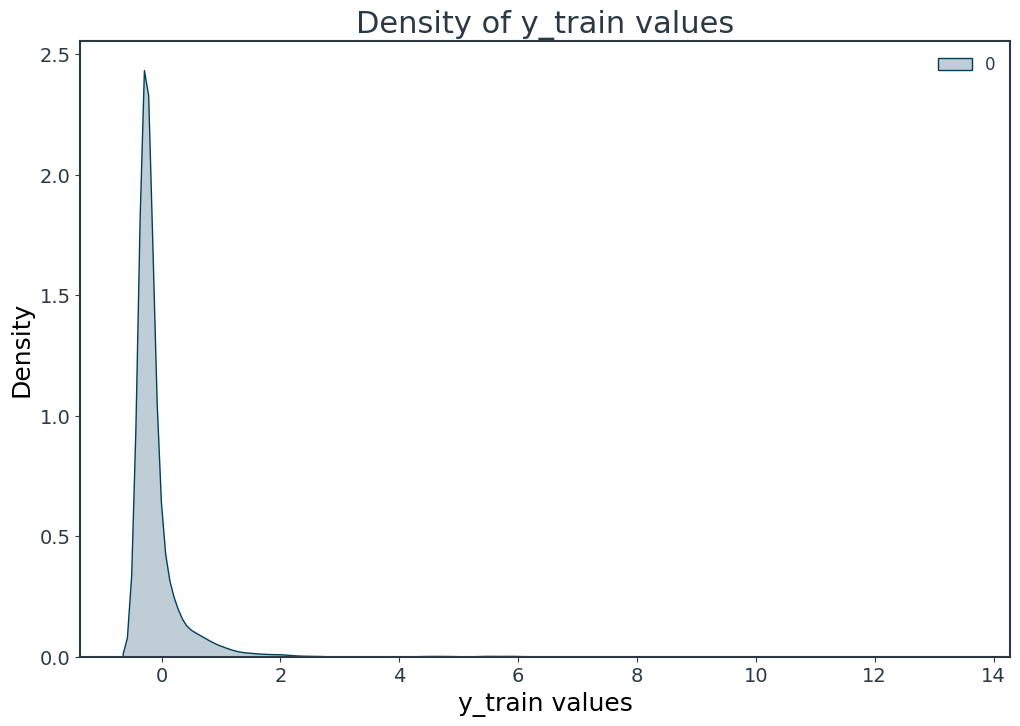

In [39]:
import seaborn as sns

sns.kdeplot(y_train.values, shade=True)
plt.title('Density of y_train values')
plt.xlabel('y_train values')
plt.ylabel('Density')
plt.show()


### Build LGBM and Improve in valid set

In [9]:
# Train LightGBM model
lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=50, learning_rate=0.1, n_estimators=200)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21293
[LightGBM] [Info] Number of data points in the train set: 45368, number of used features: 93
[LightGBM] [Info] Start training from score -0.025777


LGBMRegressor(n_estimators=200, num_leaves=50, objective='regression')

In [10]:
lgbm_model_predictions = lgbm_model.predict(X_valid)
lgbm_model_mae = mean_absolute_error(y_valid, lgbm_model_predictions)
lgbm_model_r2 = r2_score(y_valid, lgbm_model_predictions)
print(f"LGBM model - Validation MAE: {lgbm_model_mae:.3f}, Validation R2: {lgbm_model_r2:.3f}")

LGBM model - Validation MAE: 0.118, Validation R2: 0.904


In [11]:
plt.style.use('style.mplstyle')
shap.initjs()

In [12]:
# Compute SHAP values
explainer = shap.Explainer(lgbm_model)
shap_values = explainer(X_train)

In [13]:
np.mean(y_train)

-0.025776634447623226

In [14]:
# Compute base value (which is the mean)
explainer.expected_value, np.mean(y_train)

(-0.02577663441019827, -0.025776634447623226)

In [15]:
y_pred = lgbm_model.predict(X_train)

In [16]:
i_med = np.argsort(y_pred)[len(y_pred)//2]
i_max = np.argmax(y_pred)
i_80 = np.argsort(y_pred)[int(len(y_pred)*0.8)]
i_60 = np.argsort(y_pred)[int(len(y_pred)*0.6)]
i_40 = np.argsort(y_pred)[int(len(y_pred)*0.4)]
i_20 = np.argsort(y_pred)[int(len(y_pred)*0.2)]
i_min = np.argmin(y_pred)

In [17]:
lgbm_model.fit(X_train, y_train)
lgbm_model_predictions = lgbm_model.predict(X_valid)
lgbm_model_mae = mean_absolute_error(y_valid, lgbm_model_predictions)

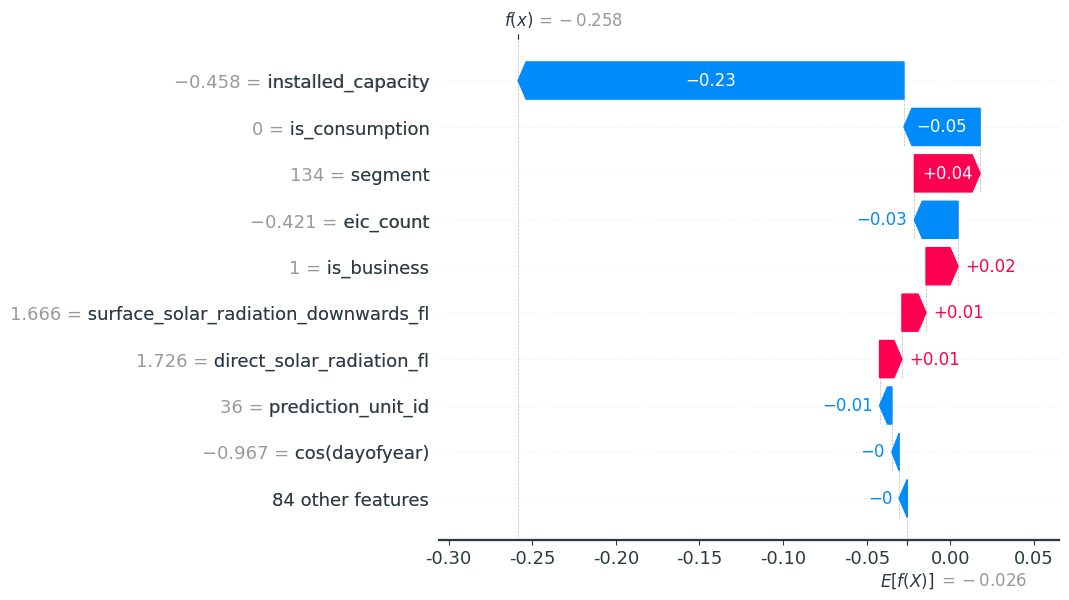

In [43]:
shap.plots.waterfall(shap_values[i_med],show=True)
plt.show()
plt.savefig("plots/waterfall_median.png")

In [41]:
shap.plots.force(shap_values[i_med], show=True)
plt.show()
plt.savefig("plots/force_median.png")

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

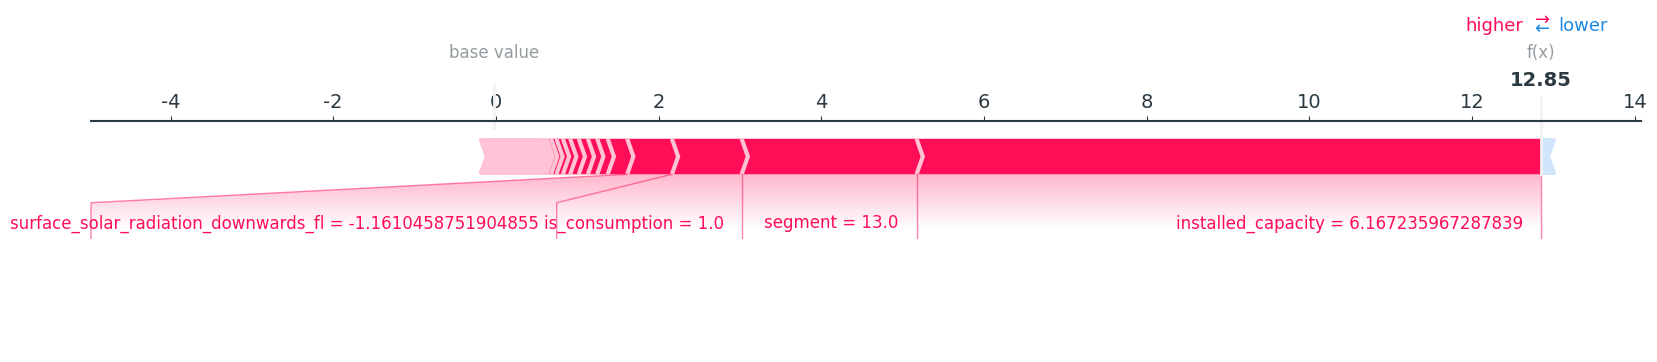

In [44]:
shap.plots.force(shap_values[i_max], show=False, matplotlib=True)
plt.show()
plt.savefig("plots/force_max.png")

<Figure size 1200x800 with 0 Axes>

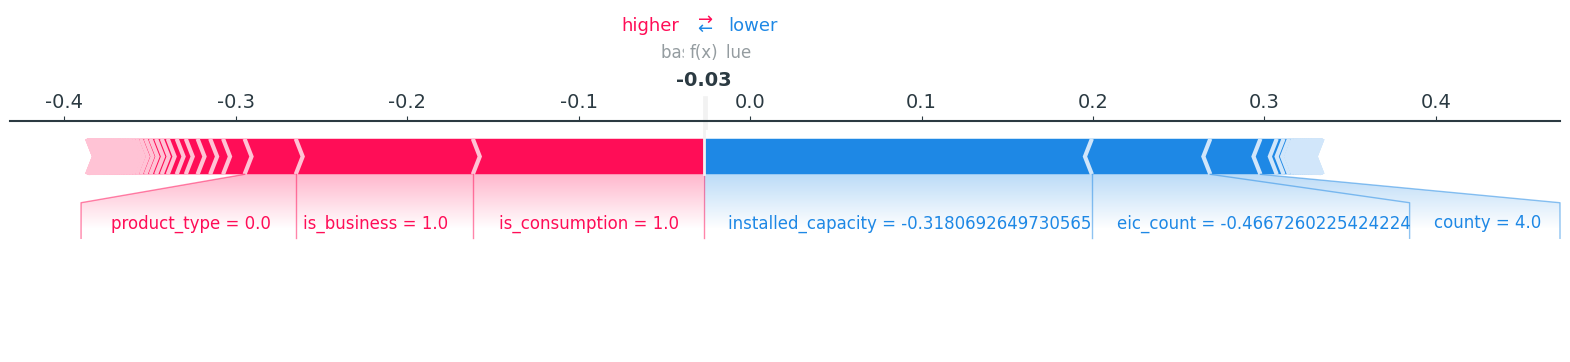

In [42]:
shap.plots.force(shap_values[i_80], show=False, matplotlib=True)
plt.show()
plt.savefig("plots/force_80.png")

<Figure size 1200x800 with 0 Axes>

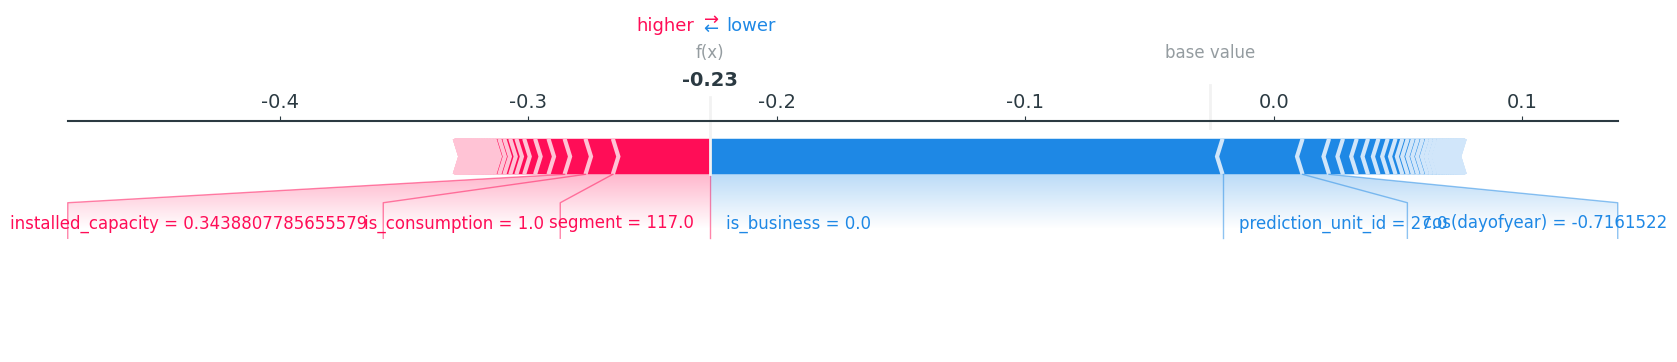

In [20]:
shap.plots.force(shap_values[i_60], show=False, matplotlib=True)
plt.show()
plt.savefig("plots/force_60.png")

<Figure size 1200x800 with 0 Axes>

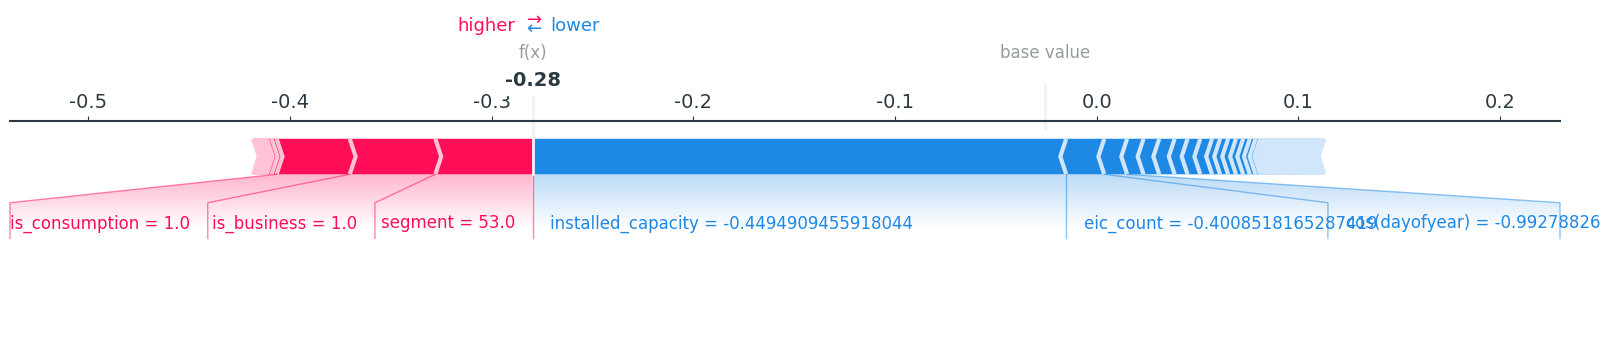

In [21]:
shap.plots.force(shap_values[i_40], show=False, matplotlib=True)
plt.show()
plt.savefig("plots/force_40.png")

<Figure size 1200x800 with 0 Axes>

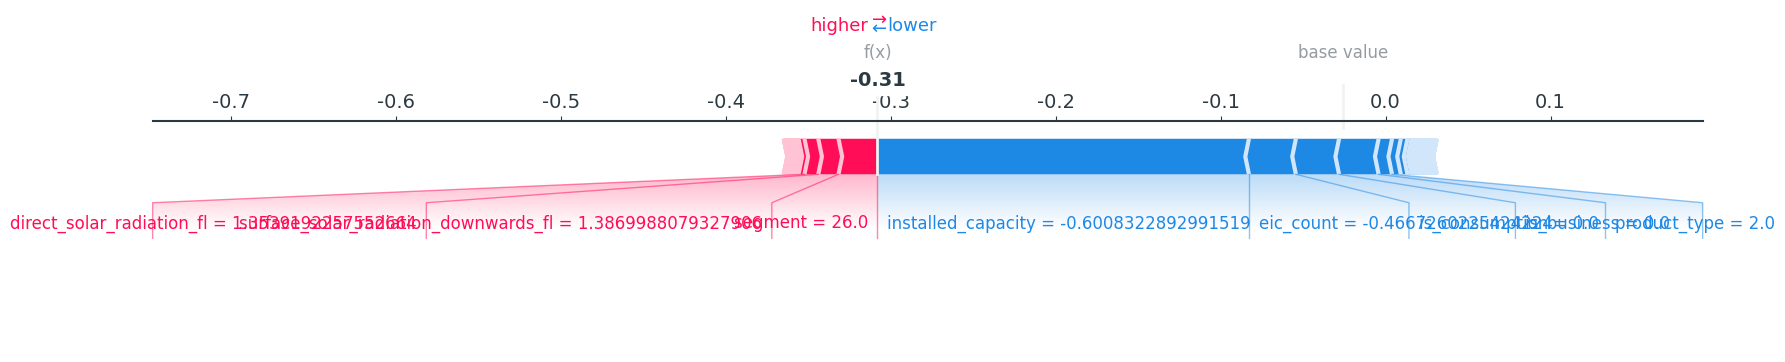

In [22]:
shap.plots.force(shap_values[i_20], show=False, matplotlib=True)
plt.show()
plt.savefig("plots/force_20.png")

<Figure size 1200x800 with 0 Axes>

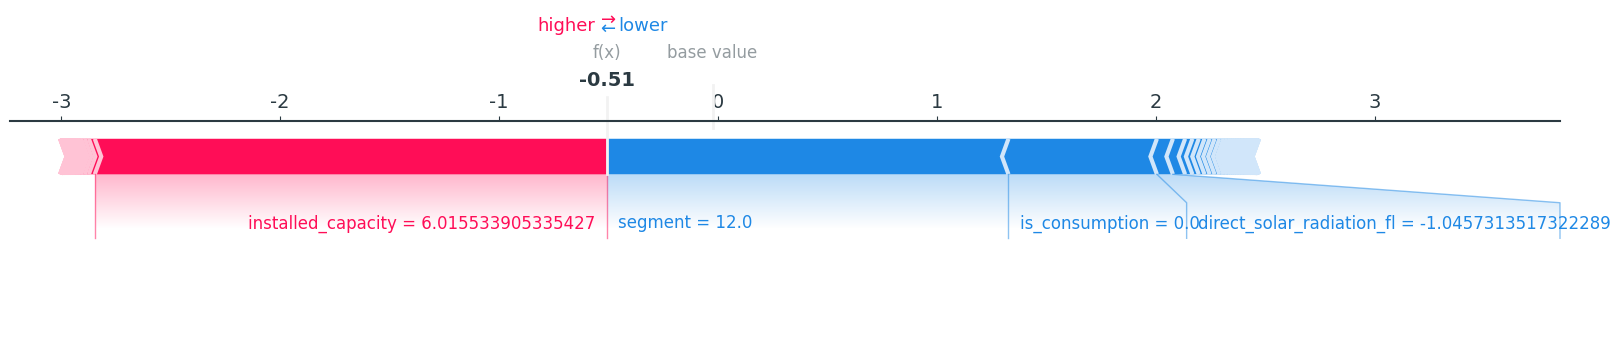

In [45]:
shap.plots.force(shap_values[i_min], show=False, matplotlib=True)
plt.show()
plt.savefig("plots/force_min.png")

Nhìn chung thì hầu hết trong mọi trường hợp, giá trị của biến `installed_capacity` sẽ đẩy giá trị của target xuống. Điều này là đáng được mong chờ khi mà với một dung tích điện nhiều hơn, người dân có thể trữ được nhiều điện hơn, từ đó ít phụ thuộc hơn hẳn vào điện năng mà enefit cung cấp. 

Tuy nhiên ở cận dưới và cận trên cho giá trị target của bộ dữ liệu lại không phản ánh được điều đó, cụ thể hơn là ở những khoảng này, giá trị SHAP tác động lên giá trị của dự đoán càng tăng lên. 

#### Global

Diễn tả hành vi mong muốn của mô hình với toạn bộ phân phối của các biến đầu vào. Thư viện SHAP làm điều này bằng cách tích hợp toàn bộ giá trị SHAP cho từng quan sát riêng lẽ trong bộ dữ liệu. 

Đầu tiên là với giá trị tuyệt đối trung bình (Mean absolute value) cho từng feature trên toàn bộ dữ liệu. Điều này lượng hóa được tầm quan trọng của từng biến (trên trung bình) các feature ảnh hưởng và đóng góp thế nào đến với giá trị dự đoán. 

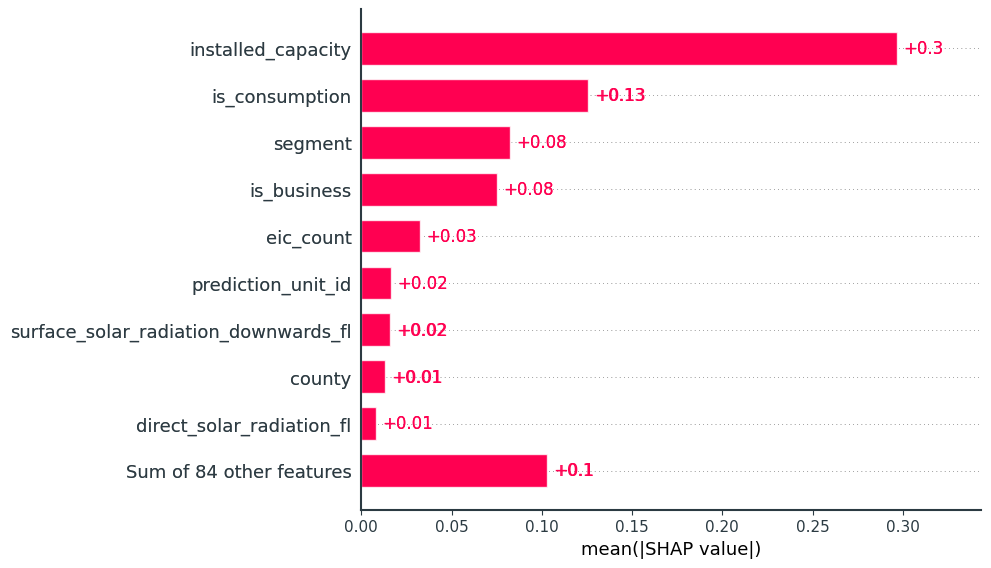

In [25]:
shap.plots.bar(shap_values, show=False)
plt.show()
plt.savefig("plots/bar.png")

Hình này cho thấy rằng trên trung bình, các biến như `installed_capacity`, `is_consumption`, `segment`, `is_business` là đóng góp nhiều nhất đến kết quả dự đoán của mô hình học máy. Tuy nhiên cũng cần lưu ý thêm là bản thân biến `segment` là tổ hợp của 2 biến `is_consumption` và `is_business`. 

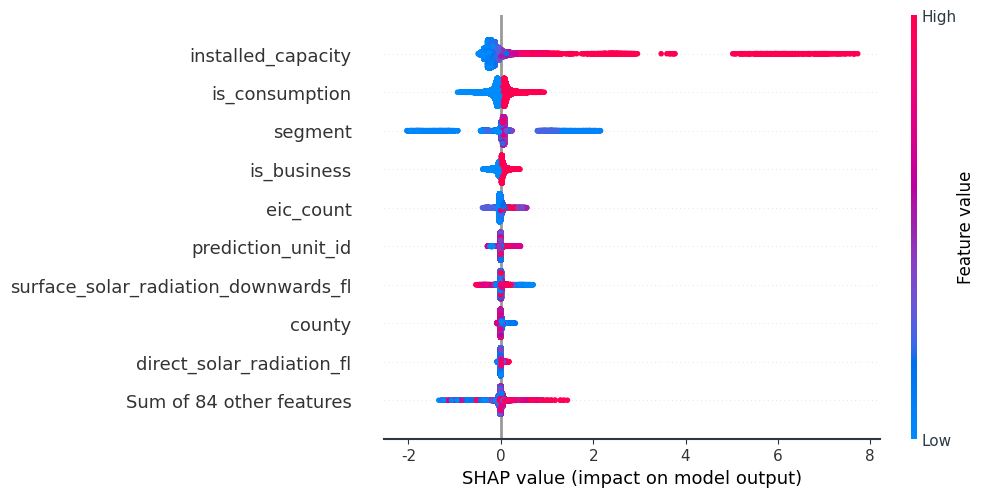

In [27]:
shap.plots.beeswarm(shap_values, show=False)
plt.show()
plt.savefig("plots/beeswarm.png")

Như hình trên chúng ta thấy rằng với giá trị của `installed_capacity` càng cao thì giá trị SHAP dương càng lớn, tức là công suất lắp đặt ảnh hưởng trực tiếp tới giá trị SHAP mà đóng góp vào đầu ra của mô hình. Điều này có nghĩa là năng lượng. Điều này có nghĩa là giá trị của mức tiêu thụ/sản xuất điện sẽ tăng lên khi mà công suất lắp đặt điện mặt trời tăng lên và ngược lại. 

In [28]:
plt.subplot(2, 1, 1)
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}
for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = X.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(X.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()
plt.savefig("plots/bar_beeswarm.png")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\1437554876.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\1437554876.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("plots/bar_beeswarm.png")


In [29]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 3))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
fig.savefig("plots/scatter_top5.png")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\3248107640.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\3248107640.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\3248107640.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19540\3248107640.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

C:\Users\lenovo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


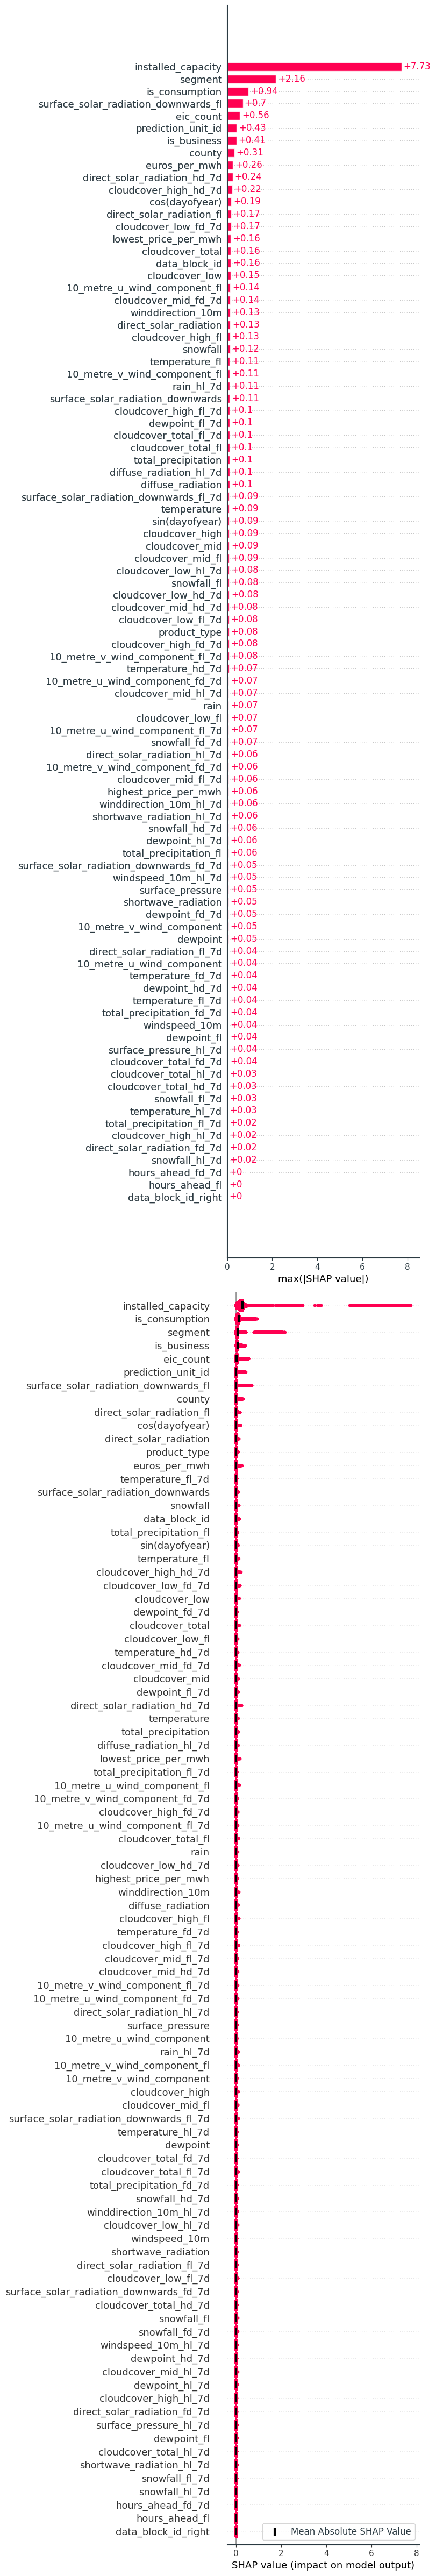

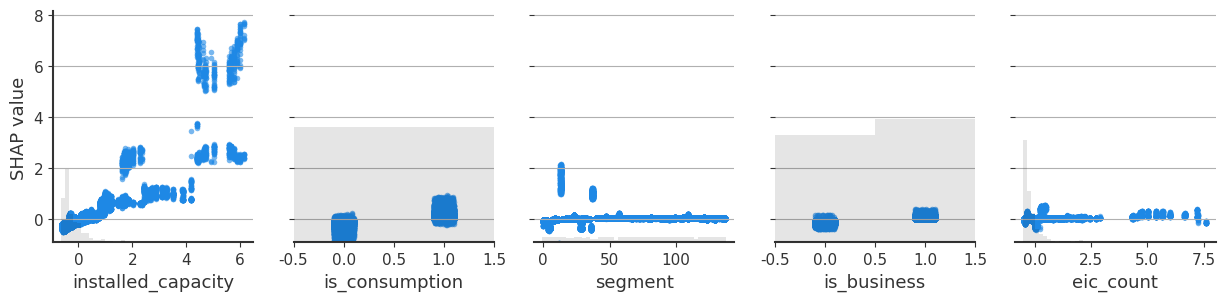

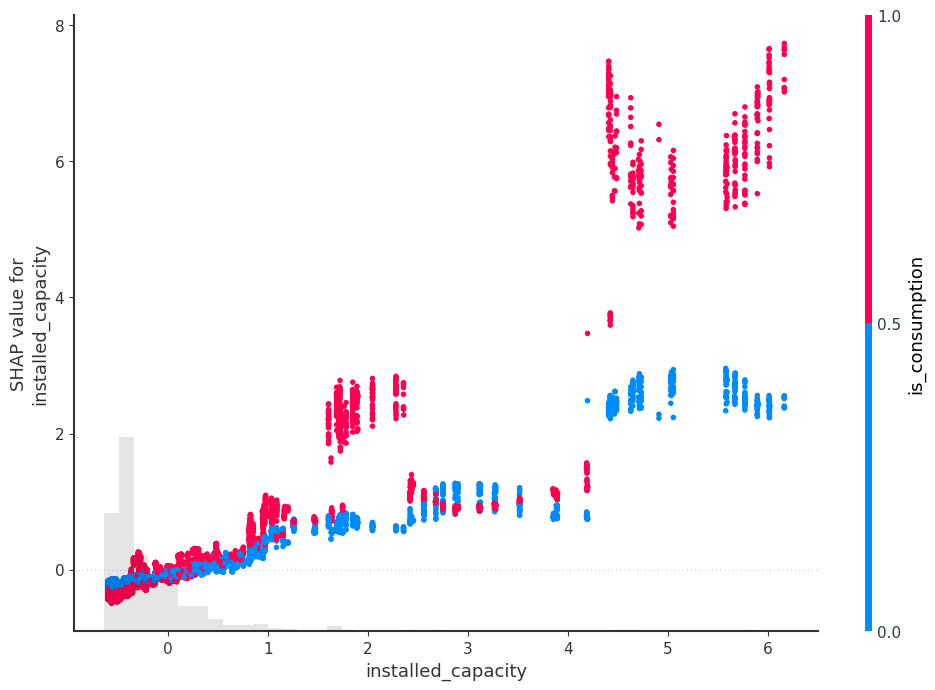

In [30]:
fig, ax = plt.subplots()
shap.plots.scatter(shap_values[:, "installed_capacity"], color=shap_values, ax=ax)
fig.savefig("plots/scatter_coloured.png")
fig.show()

Trong hình trên, ta thấy là biến `is_consumption` được chọn bởi vì biến này có sự tương tác gây ảnh hưởng lớn nhất đến biến `installed_capacity`. Điều này có thể ám chỉ công suất lắp đặt của một tấm pin mặt trời phụ thuộc vào một người nào đó có thể là người tiêu thụ hoặc là người sản xuất. 

Cụ thể hơn trong hình trên, chúng ta có thể thấy rằng đối với công suất lắp đặt càng lớn, giá trị SHAP gây ảnh hưởng lên giá trị dự đoán càng lớn, một quan sát khác đó chính là ở phân khúc công suất lắp đặt lớn này, có sự phân biệt rõ rệt giữa những người tiêu thụ và những người sản xuất. Cụ thể hơn thì những người tiêu thụ sẽ làm tăng giá trị dự đoán cho đầu ra của mô hình nhiều hơn, trong khi đó những người sản xuất sẽ làm tăng đầu ra cho giá trị dự đoán của mô hình ít hơn. 